In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 2
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.01):
    res = jnp.dot(x, rotation)
    res = (res ** 2) * -0.25
    res = jnp.exp(res)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = 5 * jnp.max(res * projected, axis = 1)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 1000
tries = 10


x_train, _, x_test, _, _ = pickle.load(open('axis_aligned_data.pickle', 'rb'))

x_train = x_train[:, :dim_in]
x_test = x_test[:, :dim_in]

rotation = special_ortho_group.rvs(dim_in)

y_train = simulate_y(x_train, rotation)

y_test = simulate_y(x_test, rotation)

sample_range = [100, 200, 400, 800, 1600]

M = 10                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

rotation

array([[-0.03869888, -0.17136301,  0.6148598 , -0.76190323, -0.10289806],
       [-0.54358189, -0.2651574 ,  0.43803723,  0.49997825, -0.43858342],
       [-0.43657543, -0.05103744,  0.20548496,  0.08190943,  0.87055376],
       [-0.69828018,  0.03415803, -0.56341725, -0.40295396, -0.17727697],
       [ 0.15756842, -0.94686571, -0.26534458, -0.02107528,  0.08812262]])

In [2]:
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.01):
    res = jnp.dot(x, rotation)
    res = (res ** 2) * -0.25
    res = jnp.exp(res)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = 5 * jnp.max(res * projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test
norm_H = linalg.norm(true_H, ord = 2)

In [3]:
np.set_printoptions(precision=5, suppress=True)
true_H/two_one_norm(true_H)

Array([[ 0.05348,  0.11532,  0.04455,  0.03687,  0.2705 ],
       [ 0.11532,  0.63589,  0.43633,  0.6447 ,  0.28595],
       [ 0.04455,  0.43633,  0.33612,  0.52737, -0.03596],
       [ 0.03687,  0.6447 ,  0.52737,  0.85035, -0.24746],
       [ 0.2705 ,  0.28595, -0.03596, -0.24746,  1.59645]], dtype=float32)

In [4]:
np.linalg.matrix_rank(true_H)

2

# Save training history

In [5]:
lifetime = 5
n_estimators = M
from Mondrian_RF.Mondrian_forest import MondrianForestTransformer

# Mondrian Forest
forests = {}
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    forests[n_sim] = []
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        forest = MondrianForestTransformer(n_estimators=n_estimators, lifetime=lifetime, step_size=0.2, random_state=n_sim * (trial + 1))
        forest.fit(x_train[:n_sim], y_train[:n_sim])
        forests[n_sim].append(forest)

100%|██████████| 10/10 [02:23<00:00, 14.32s/it]


100%|██████████| 10/10 [36:22<00:00, 218.30s/it]


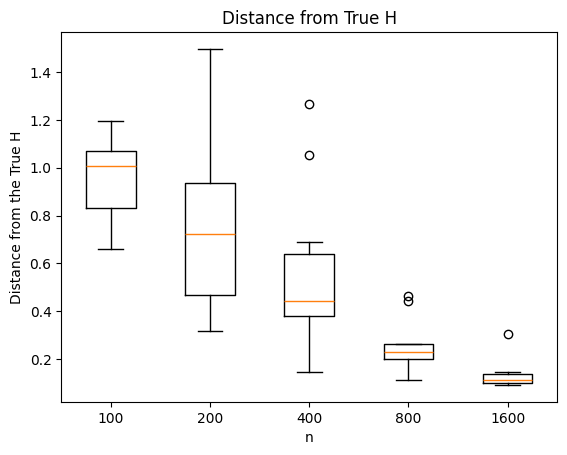

In [6]:
H_est = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'H': []}
    for trial in tqdm(range(tries)):
        H_0 = forests[n_sim][trial].estimate_H_finite_diff()
        dist['H'].append(H_0)
    H_est.append(dist)
from util import *
plot_H_estimates(H_est, true_H, get_angle_distance, sample_range, active)

In [7]:
lifetime_max = 5
n_sim = 1600
results = []
results.append(
    evaluate_all_lifetimes(x_train[:n_sim,], 
                           y_train[:n_sim], 
                           x_test, y_test, M, lifetime_max, delta))

In [8]:
x_train_transformed, x_test_transformed = transform_data(true_H/two_one_norm(true_H), x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [10]:
H_1 = H_est[4]['H'][0]/two_one_norm(H_est[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_1, x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

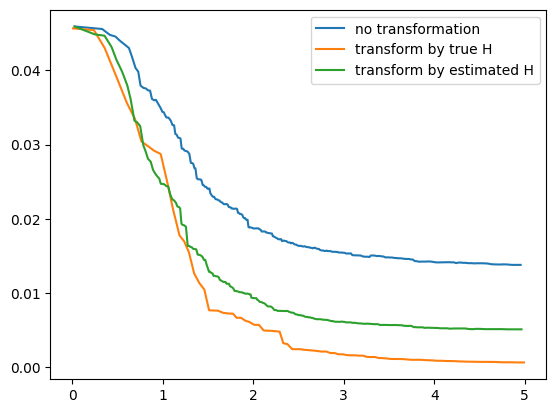

In [11]:
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H')
plt.legend()

In [12]:
lifetime = 5

stats = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'history': []}
    for trial in tqdm(range(tries)):
        history, w_trees = train(
            x_train_transformed[:n_sim, ], y_train[:n_sim, ], M, lifetime, delta
        )
        dist['history'].append([history, w_trees])
    stats.append(dist)

100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


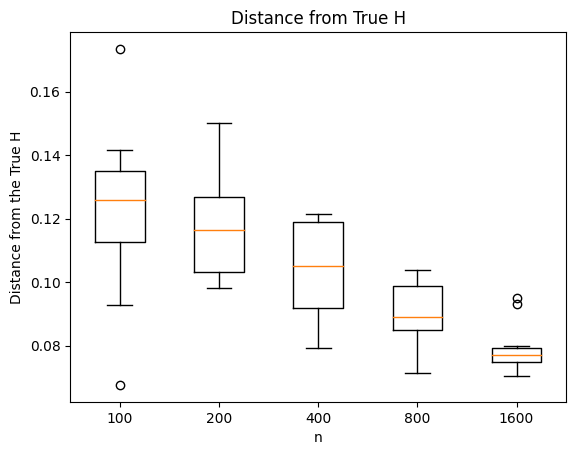

In [ ]:
raw_H_estimates = get_H_estimates(stats, x_train_transformed, y_train, M, sample_range, tries = 10)
def get_angle_distance_1(H, truth, active, dim_in):
    return get_angle_distance(np.matmul(H_1, H), truth, active, dim_in)

plot_H_estimates(raw_H_estimates, true_H, get_angle_distance_1, sample_range, active, dim_in)

In [13]:
H_2 = raw_H_estimates[4]['H'][0]/two_one_norm(raw_H_estimates[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_2, x_train_transformed, x_test_transformed)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H - 1st')
plt.plot(results[3][0]['times'], results[3][0]['mse'], label = 'transform by estimated H - 2nd')
plt.legend()

NameError: name 'raw_H_estimates' is not defined